Follows along with the IBM Quantum hello world project: https://docs.quantum.ibm.com/guides/hello-world

Includes my own commentary.

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_bloch_multivector, plot_distribution
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

# Display all output in each cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create Bell state (entangled qubits)

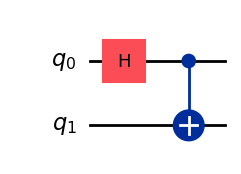

In [3]:
# Create a new circuit with two qubits.
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0.
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0.
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")

#### Let me break it down

The Hadamard gate puts qubit 0 into superposition, rotating it from the default initialized spin-up state of |0> to |+>, halfway between |0> and |1>.

Then, the CNOT gate is what entangles the two qubits. If qubit 0 is |0>, qubit 1 stays at its value (|0> in this case), but if qubit 0 is |1>, qubit 1 flips its value (to |1> in this case).

So, we'd expect measurements of both qubits to be random, split equally between |0> and |1>. The 50-50 measurement of qubit 0 is due to its superposition, not its entanglement. But, the 50-50 measurement of qubit 1 is due to its entanglement to the superpositioned qubit 0.

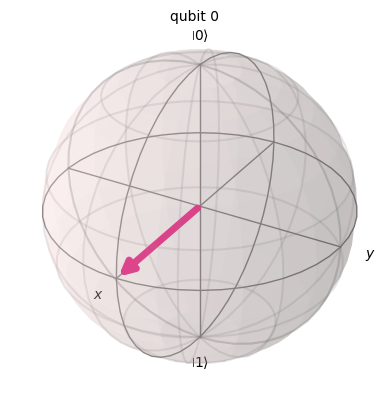

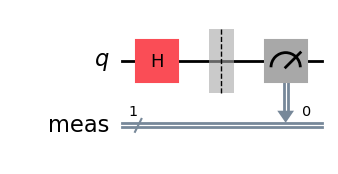

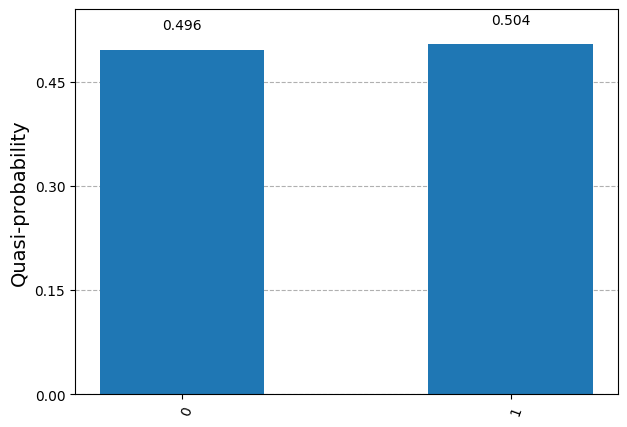

{'1': 504, '0': 496}


In [4]:
demo_qc = QuantumCircuit(1)
demo_qc.h(0)

demo_state = Statevector(demo_qc)
plot_bloch_multivector(demo_state)

demo_qc.measure_all()
demo_qc.draw("mpl")

# Construct an ideal simulator with SamplerV2
sampler = SamplerV2()
job = sampler.run([demo_qc], shots=1000)

# Perform an ideal simulation
result = job.result()
counts = result[0].data.meas.get_counts()

plot_distribution(counts)

print(counts)

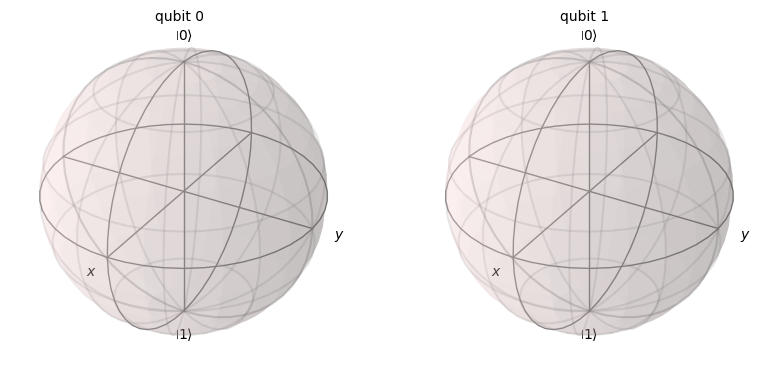

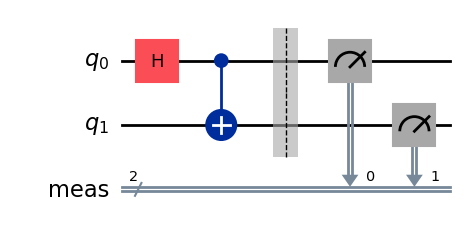

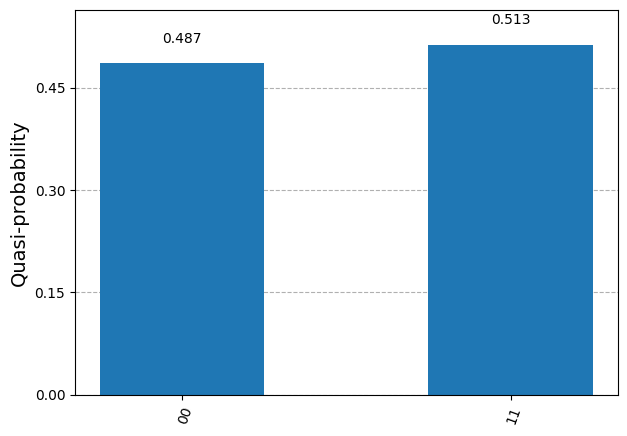

{'11': 513, '00': 487}


In [5]:
# Now on the tutorial circuit.
demo_qc = QuantumCircuit(2)
demo_qc.h(0)
demo_qc.cx(0, 1)
 
demo_state = Statevector(demo_qc)
plot_bloch_multivector(demo_state)

demo_qc.measure_all()
demo_qc.draw("mpl")

sampler = SamplerV2()
job = sampler.run([demo_qc], shots=1000)

result = job.result()
counts = result[0].data.meas.get_counts()

plot_distribution(counts)

print(counts)

Notice we can't plot the Bloch sphere of the entangled state.

Notice the output in the two-qubit circuit is split between two outcomes, 00 and 11 (whereas the single-qubit circuit is split betwee 1 and 0). The possible outcomes 01 and 10 never occur, because the two qubits are entangled such that their states will always match. You could have them always be opposite by initializing one with an X gate to set it to |1> before entangling with the CNOT gate.

Below, when we plot the observables, we see the same correlation.

### Set up observables

"Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable."

In [6]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

These are Pauli gates to apply to the circuit and thus gain information about it.

"Here, something like the ZZ operator is a shorthand for the tensor product 
Z
⊗
Z
Z⊗Z, which means measuring Z on qubit 1 and Z on qubit 0 together, and obtaining information about the correlation between qubit 1 and qubit 0. Expectation values like this are also typically written as ⟨Z_1 Z_0⟩.

If the state is entangled, then the measurement of ⟨Z_1 Z_0⟩ should be 1."

TODO: Refresh on basic gates. X is simply a not gate, but where does Z take us?

### Optimize circuit

Now we need to optimize the instruction set for the particular hardware you're using. IBM has a number of machines you can use, each with different architecture. Machines can have different basis gates to construct all the possible high-level gates. Different machines also have different networked connection of the qubits. So, the actual instructions carried out to achieve the circuit we've designed will be different and more complex than the circuit as we see it first. This can result in differing circuit depths (longest path), and thus different degrees of error and noise. This is also affected by the depth capacity of the qubits (I can't remember the exact terminology, but basically how long a qubit can run before it loses fidelity ... decoheres?).

Here, we're not optimizing the machine we select. We're just grabbing the "least busy" machine and optimizing the instruction set for that machine:

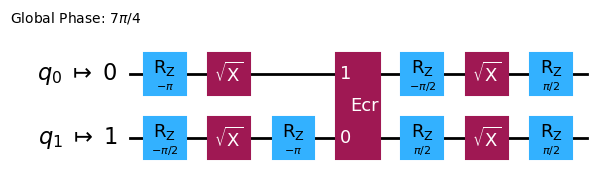

In [7]:
# If you have not previously saved your credentials, follow instructions at
# https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.
# Or, run ../scripts/setup_IBM_channel.py
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an Instruction Set Architecture (ISA) circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

### Execute with quantum primitives

Using many shots to get a probability distribution and mitigate quantum error, we'll use the Estimator class (the other primitive being the Sampler) to estimate the observables' values.

In [8]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One primitive unified bloc (PUB), with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later.
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cydxgvvnrmz00086f3d0


In [9]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [10]:
for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [-0.01586636  0.00813659 -0.00653973  0.0047958   0.98421188  0.9944363 ]


In [11]:
observables

[SparsePauliOp(['IZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XX'],
               coeffs=[1.+0.j])]

In [12]:
job_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [13]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

In [14]:
pub_result.data

DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,))

In [15]:
pub_result.data.evs

array([-0.01586636,  0.00813659, -0.00653973,  0.0047958 ,  0.98421188,
        0.9944363 ])

In [16]:
list(zip(observables, pub_result.data.evs))

[(SparsePauliOp(['IZ'],
                coeffs=[1.+0.j]),
  np.float64(-0.015866356459056413)),
 (SparsePauliOp(['IX'],
                coeffs=[1.+0.j]),
  np.float64(0.008136593055926362)),
 (SparsePauliOp(['ZI'],
                coeffs=[1.+0.j]),
  np.float64(-0.0065397322797098)),
 (SparsePauliOp(['XI'],
                coeffs=[1.+0.j]),
  np.float64(0.004795803671787186)),
 (SparsePauliOp(['ZZ'],
                coeffs=[1.+0.j]),
  np.float64(0.984211878946162)),
 (SparsePauliOp(['XX'],
                coeffs=[1.+0.j]),
  np.float64(0.9944363022595143))]

This only sat in the queue for 3 seconds and took 5 seconds to run. That's much better than my first circuit of simply measuring two qubits, that also grabbed the "least busy" machine, and sat in queue for almost 3 hours and took 9 seconds to run.

#### Or use a "fake provider" or simulator

Good for small circuits, but unfeasible on circuits large enough to warrant quantum computing.

In [17]:
 
# Use the following code instead if you want to run on a simulator:
backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

In [18]:
list(zip(observables, pub_result.data.evs))

[(SparsePauliOp(['IZ'],
                coeffs=[1.+0.j]),
  np.float64(0.0498046875)),
 (SparsePauliOp(['IX'],
                coeffs=[1.+0.j]),
  np.float64(0.0693359375)),
 (SparsePauliOp(['ZI'],
                coeffs=[1.+0.j]),
  np.float64(0.126953125)),
 (SparsePauliOp(['XI'],
                coeffs=[1.+0.j]),
  np.float64(0.14697265625)),
 (SparsePauliOp(['ZZ'],
                coeffs=[1.+0.j]),
  np.float64(0.7919921875)),
 (SparsePauliOp(['XX'],
                coeffs=[1.+0.j]),
  np.float64(0.77880859375))]

In [19]:
list(zip(pub_result.data.stds, pub_result.data.evs))

[(np.float64(0.015605609007528552), np.float64(0.0498046875)),
 (np.float64(0.015587396374165277), np.float64(0.0693359375)),
 (np.float64(0.015498573712514632), np.float64(0.126953125)),
 (np.float64(0.015455321177949649), np.float64(0.14697265625)),
 (np.float64(0.009539550368090375), np.float64(0.7919921875)),
 (np.float64(0.009800963240652221), np.float64(0.77880859375))]

So, a little different between the simulated distribution and true distribution, but general agreement that ZZ and XX are close to 1 and the rest of the gates are close to 0.

It looks like the simulator is one with builtin noise.

### Analyze the results

There are a number of post-processing steps you could take. Plotting is one of them. (A barchart would be more sensible I think.)

Text(0.5, 0, 'Observables')

Text(0, 0.5, 'Values')

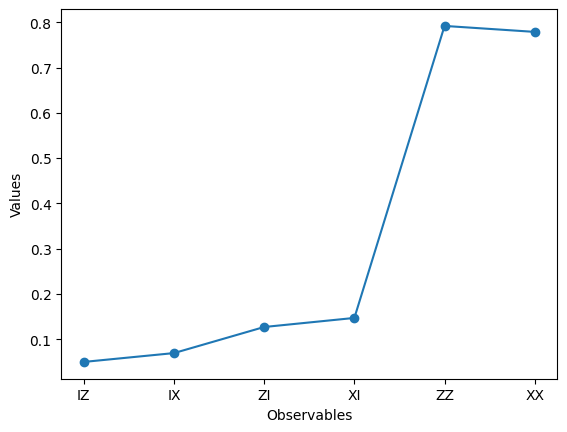

In [20]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

"Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement."